<a href="https://colab.research.google.com/github/yaroslavtsepkov/MLAI/blob/lab_4/Lab4_N51.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


In [32]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# Analyse data

In [33]:
data = pd.read_csv('/content/drive/Shared drives/UNLIMITED/data/mlai_labs/data4_n51.csv')

In [34]:
data

,name,area,class,gray_Mean,gray_Variance,gray_Skewness,gray_Kurtosis,gray_Perc.01%,gray_Perc.10%,gray_Perc.50%,gray_Perc.90%,gray_Perc.99%,"gray_S(1,0)AngScMom","gray_S(1,0)Contrast","gray_S(1,0)Correlat","gray_S(1,0)SumOfSqs","gray_S(1,0)InvDfMom","gray_S(1,0)SumAverg","gray_S(1,0)SumVarnc","gray_S(1,0)SumEntrp","gray_S(1,0)Entropy","gray_S(1,0)DifVarnc","gray_S(1,0)DifEntrp","gray_S(0,1)AngScMom","gray_S(0,1)Contrast","gray_S(0,1)Correlat","gray_S(0,1)SumOfSqs","gray_S(0,1)InvDfMom","gray_S(0,1)SumAverg","gray_S(0,1)SumVarnc","gray_S(0,1)SumEntrp","gray_S(0,1)Entropy","gray_S(0,1)DifVarnc","gray_S(0,1)DifEntrp","gray_S(1,1)AngScMom","gray_S(1,1)Contrast","gray_S(1,1)Correlat","gray_S(1,1)SumOfSqs","gray_S(1,1)InvDfMom","gray_S(1,1)SumAverg",...,"v_S(5,0)DifVarnc","v_S(5,0)DifEntrp","v_S(0,5)AngScMom","v_S(0,5)Contrast","v_S(0,5)Correlat","v_S(0,5)SumOfSqs","v_S(0,5)InvDfMom","v_S(0,5)SumAverg","v_S(0,5)SumVarnc","v_S(0,5)SumEntrp","v_S(0,5)Entropy","v_S(0,5)DifVarnc","v_S(0,5)DifEntrp","v_S(5,5)AngScMom","v_S(5,5)Contrast","v_S(5,5)Correlat","v_S(5,5)SumOfSqs","v_S(5,5)InvDfMom","v_S(5,5)SumAverg","v_S(5,5)SumVarnc","v_S(5,5)SumEntrp","v_S(5,5)Entropy","v_S(5,5)DifVarnc","v_S(5,5)DifEntrp","v_S(5,-5)AngScMom","v_S(5,-5)Contrast","v_S(5,-5)Correlat","v_S(5,-5)SumOfSqs","v_S(5,-5)InvDfMom","v_S(5,-5)SumAverg","v_S(5,-5)SumVarnc","v_S(5,-5)SumEntrp","v_S(5,-5)Entropy","v_S(5,-5)DifVarnc","v_S(5,-5)DifEntrp",v_GrMean,v_GrVariance,v_GrSkewness,v_GrKurtosis,v_GrNonZeros
0,90.result_100x401.bmp,144,D,44.118056,5.506896,0.912415,1.190327,41,41,44,47,52,0.037047,1.568182,0.850315,3.821970,0.570455,86.037879,7220.921229,1.176013,1.543663,0.652617,0.493807,0.032685,2.477273,0.742685,3.537879,0.526028,85.946970,7206.187925,1.156579,1.581418,1.063692,0.584875,0.028038,4.239669,0.557306,3.471074,0.431294,85.809917,...,9.603964,0.925799,0.017645,28.654762,-0.026004,11.458333,0.352559,153.011905,23054.898626,1.263111,1.872731,21.318212,0.980323,0.017493,34.081633,-0.063611,13.367347,0.243830,154.489796,23514.588996,1.242988,1.820715,25.175403,1.029100,0.020825,23.877551,-0.316841,6.938776,0.118991,150.979592,22484.523855,1.072499,1.725431,15.747406,0.922657,3.232823,5.178854,1.151424,1.082461,0.960000
1,90.result_101x394.bmp,144,D,45.861111,6.675154,0.114718,-1.013348,41,43,46,50,51,0.028495,1.787879,0.866209,4.852273,0.578788,89.696970,7849.475764,1.240555,1.621411,0.845746,0.533485,0.029815,1.477273,0.887411,4.685606,0.614840,89.522727,7817.406227,1.246787,1.602612,0.821537,0.505091,0.023598,3.123967,0.762432,4.710744,0.464754,89.504132,...,9.078113,0.867216,0.013960,15.273810,0.189657,7.261905,0.248156,150.869048,22414.122064,1.230487,1.927365,8.906930,0.913634,0.018950,46.142857,-0.773064,10.336735,0.174812,151.367347,22630.733637,0.951830,1.785360,36.287332,1.067346,0.030196,5.775510,0.460102,3.806122,0.434613,149.816327,22128.184499,1.113384,1.604067,3.061485,0.725396,3.185899,2.140045,0.600060,0.196739,0.990000
2,90.result_101x434.bmp,144,D,142.673611,405.942081,-0.556972,-0.527809,97,112,146,167,174,0.005797,26.469697,0.964497,357.439394,0.164683,284.424242,81284.695661,1.899832,2.281329,13.153281,0.970307,0.005825,12.583333,0.983869,374.068182,0.131512,283.386364,80789.631679,1.886753,2.274487,3.707754,0.730388,0.005362,71.264463,0.901966,348.301653,0.037109,284.438017,...,289.185631,1.435244,0.006519,529.880952,0.250763,338.726190,0.002241,410.404762,167912.281303,1.714528,2.196640,455.503498,1.216536,0.010204,1571.183673,-0.513667,499.397959,0.000886,409.591837,167008.867881,1.542753,1.991226,1455.684851,1.350559,0.011454,98.346939,0.652564,132.275510,0.100926,414.183673,170760.592966,1.518179,1.954365,74.687848,1.157122,11.591785,19.220514,0.576016,-0.736670,1.000000
3,90.result_101x464.bmp,144,D,229.006944,9.034674,-0.370313,-0.979858,223,224,229,233,233,0.051050,1.810606,0.885280,5.988636,0.582110,456.159091,207014.821078,1.202976,1.496622,0.870032,0.532726,0.073921,0.424242,0.976548,6.943182,0.806061,455.954545,206837.358274,

In [35]:
data['class'].unique()

array(['D', 'H', 'M', 'O', 'V'], dtype=object)

# Preprocessing data

In [36]:
y = data['class']
x = data.drop(columns=['class','name'])

In [37]:
scaler = MinMaxScaler()
x_scaled = pd.DataFrame(data = scaler.fit_transform(x), columns=x.columns)

In [38]:
x_scaled

,area,gray_Mean,gray_Variance,gray_Skewness,gray_Kurtosis,gray_Perc.01%,gray_Perc.10%,gray_Perc.50%,gray_Perc.90%,gray_Perc.99%,"gray_S(1,0)AngScMom","gray_S(1,0)Contrast","gray_S(1,0)Correlat","gray_S(1,0)SumOfSqs","gray_S(1,0)InvDfMom","gray_S(1,0)SumAverg","gray_S(1,0)SumVarnc","gray_S(1,0)SumEntrp","gray_S(1,0)Entropy","gray_S(1,0)DifVarnc","gray_S(1,0)DifEntrp","gray_S(0,1)AngScMom","gray_S(0,1)Contrast","gray_S(0,1)Correlat","gray_S(0,1)SumOfSqs","gray_S(0,1)InvDfMom","gray_S(0,1)SumAverg","gray_S(0,1)SumVarnc","gray_S(0,1)SumEntrp","gray_S(0,1)Entropy","gray_S(0,1)DifVarnc","gray_S(0,1)DifEntrp","gray_S(1,1)AngScMom","gray_S(1,1)Contrast","gray_S(1,1)Correlat","gray_S(1,1)SumOfSqs","gray_S(1,1)InvDfMom","gray_S(1,1)SumAverg","gray_S(1,1)SumVarnc","gray_S(1,1)SumEntrp",...,"v_S(5,0)DifVarnc","v_S(5,0)DifEntrp","v_S(0,5)AngScMom","v_S(0,5)Contrast","v_S(0,5)Correlat","v_S(0,5)SumOfSqs","v_S(0,5)InvDfMom","v_S(0,5)SumAverg","v_S(0,5)SumVarnc","v_S(0,5)SumEntrp","v_S(0,5)Entropy","v_S(0,5)DifVarnc","v_S(0,5)DifEntrp","v_S(5,5)AngScMom","v_S(5,5)Contrast","v_S(5,5)Correlat","v_S(5,5)SumOfSqs","v_S(5,5)InvDfMom","v_S(5,5)SumAverg","v_S(5,5)SumVarnc","v_S(5,5)SumEntrp","v_S(5,5)Entropy","v_S(5,5)DifVarnc","v_S(5,5)DifEntrp","v_S(5,-5)AngScMom","v_S(5,-5)Contrast","v_S(5,-5)Correlat","v_S(5,-5)SumOfSqs","v_S(5,-5)InvDfMom","v_S(5,-5)SumAverg","v_S(5,-5)SumVarnc","v_S(5,-5)SumEntrp","v_S(5,-5)Entropy","v_S(5,-5)DifVarnc","v_S(5,-5)DifEntrp",v_GrMean,v_GrVariance,v_GrSkewness,v_GrKurtosis,v_GrNonZeros
0,0.0,0.093097,0.002306,0.738926,0.195232,0.090047,0.089202,0.093458,0.099057,0.117925,0.145985,0.008881,0.682202,0.001715,0.661711,0.092889,0.023323,0.351728,0.434975,0.003145,0.204529,0.133196,0.010410,0.481985,0.001723,0.603269,0.092289,0.023163,0.339129,0.452866,0.004359,0.275995,0.108463,0.019419,0.294187,0.001710,0.525448,0.092202,0.023092,0.339265,...,0.003481,0.383923,0.058045,0.006708,0.463334,0.006262,0.479974,0.185148,0.075190,0.521339,0.674874,0.005280,0.419855,0.032139,0.007001,0.459602,0.007516,0.319964,0.188937,0.077343,0.598394,0.758153,0.005434,0.485921,0.043879,0.002644,0.324521,0.002731,0.156276,0.182512,0.073315,0.446873,0.694572,0.001810,0.425097,0.098586,0.017354,0.583331,0.239235,0.916667
1,0.0,0.101282,0.002848,0.598293,0.045040,0.090047,0.098592,0.102804,0.113208,0.113208,0.109101,0.010452,0.716562,0.002204,0.671678,0.101476,0.026173,0.398628,0.480365,0.005011,0.242805,0.120285,0.005572,0.773942,0.002315,0.713313,0.100679,0.025933,0.403506,0.465159,0.002899,0.203344,0.088991,0.013670,0.623992,0.002358,0.568036,0.100866,0.025965,0.392933,...,0.003284,0.343341,0.042406,0.003492,0.577117,0.003953,0.337390,0.179881,0.072379,0.498756,0.708473,0.002147,0.372755,0.036277,0.009524,0.088709,0.005807,0.229251,0.181257,0.073463,0.391825,0.736161,0.007863,0.512761,0.071943,0.000598,0.726859,0.001494,0.572116,0.179664,0.071756,0.476857,0.617999,0.000328,0.290220,0.096789,0.006405,0.443164,0.162811,0.979167
2,0.0,0.555874,0.187952,0.479874,0.078132,0.355450,0.422535,0.570093,0.665094,0.693396,0.011199,0.186884,0.929047,0.169565,0.176394,0.558436,0.359236,0.877697,0.865634,0.123887,0.664193,0.012354,0.059309,0.968527,0.192899,0.114435,0.555548,0.356571,0.860218,0.854863,0.020299,0.408501,0.009004,0.364790,0.848337,0.182010,0.023724,0.558041,0.358471,0.857257,...,0.108455,0.736830,0.010827,0.127180,0.609357,0.186362,0.001542,0.817847,0.710500,0.833824,0.874074,0.114877,0.586685,0.011445,0.328540,0.224319,0.281648,0.000652,0.816384,0.707317,0.811068,0.864217,0.318134,0.711510,0.015815,0.011062,0.826524,0.052199,0.132474,0.826873,0.721819,0.773722,0.839016,0.008696,0.585411,0.418574,0.067946,0.437052,0.082273,1.000000
3,0.0,0.961261,0.003942,0.512782,0.047323,0.952607,0.948357,0.957944,0.976415,0.971698,0.206385,0.010614,0.757791,0.002744,0.675651,0.961440,0.929480,0.371321,0.407512,0.005245,0.242074,0.318718,0.000477,0.953758,0.003480,0.950249,0.960450,0.927694,0.370190,0.305252,0.003486,0.030944,0.189948,0.008858,0.784334,0

In [39]:
x_scaled.describe()

,area,gray_Mean,gray_Variance,gray_Skewness,gray_Kurtosis,gray_Perc.01%,gray_Perc.10%,gray_Perc.50%,gray_Perc.90%,gray_Perc.99%,"gray_S(1,0)AngScMom","gray_S(1,0)Contrast","gray_S(1,0)Correlat","gray_S(1,0)SumOfSqs","gray_S(1,0)InvDfMom","gray_S(1,0)SumAverg","gray_S(1,0)SumVarnc","gray_S(1,0)SumEntrp","gray_S(1,0)Entropy","gray_S(1,0)DifVarnc","gray_S(1,0)DifEntrp","gray_S(0,1)AngScMom","gray_S(0,1)Contrast","gray_S(0,1)Correlat","gray_S(0,1)SumOfSqs","gray_S(0,1)InvDfMom","gray_S(0,1)SumAverg","gray_S(0,1)SumVarnc","gray_S(0,1)SumEntrp","gray_S(0,1)Entropy","gray_S(0,1)DifVarnc","gray_S(0,1)DifEntrp","gray_S(1,1)AngScMom","gray_S(1,1)Contrast","gray_S(1,1)Correlat","gray_S(1,1)SumOfSqs","gray_S(1,1)InvDfMom","gray_S(1,1)SumAverg","gray_S(1,1)SumVarnc","gray_S(1,1)SumEntrp",...,"v_S(5,0)DifVarnc","v_S(5,0)DifEntrp","v_S(0,5)AngScMom","v_S(0,5)Contrast","v_S(0,5)Correlat","v_S(0,5)SumOfSqs","v_S(0,5)InvDfMom","v_S(0,5)SumAverg","v_S(0,5)SumVarnc","v_S(0,5)SumEntrp","v_S(0,5)Entropy","v_S(0,5)DifVarnc","v_S(0,5)DifEntrp","v_S(5,5)AngScMom","v_S(5,5)Contrast","v_S(5,5)Correlat","v_S(5,5)SumOfSqs","v_S(5,5)InvDfMom","v_S(5,5)SumAverg","v_S(5,5)SumVarnc","v_S(5,5)SumEntrp","v_S(5,5)Entropy","v_S(5,5)DifVarnc","v_S(5,5)DifEntrp","v_S(5,-5)AngScMom","v_S(5,-5)Contrast","v_S(5,-5)Correlat","v_S(5,-5)SumOfSqs","v_S(5,-5)InvDfMom","v_S(5,-5)SumAverg","v_S(5,-5)SumVarnc","v_S(5,-5)SumEntrp","v_S(5,-5)Entropy","v_S(5,-5)DifVarnc","v_S(5,-5)DifEntrp",v_GrMean,v_GrVariance,v_GrSkewness,v_GrKurtosis,v_GrNonZeros
count,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,...,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000,7956.000000
mean,0.439936,0.312955,0.051081,0.607075,0.110951,0.253289,0.277085,0.313716,0.351545,0.369235,0.130863,0.056464,0.813819,0.046683,0.584787,0.313396,0.209480,0.536242,0.573654,0.041883,0.322894,0.133300,0.047520,0.802464,0.050767,0.561724,0.313050,0.209320,0.532934,0.572859,0.035181,0.316651,0.113440,0.066729,0.755818,0.047826,0.521507,0.313538,0.209808,0.532268,...,0.041187,0.422968,0.073861,0.037343,0.537163,0.051752,0.289344,0.385422,0.289411,0.545778,0.693634,0.034112,0.439753,0.057285,0.040122,0.428152,0.043162,0.263372,0.387697,0.292248,0.562146,0.723870,0.037179,0.461278,0.060489,0.030468,0.400254,0.036964,0.255641,0.385910,0.288187,0.531573,0.717856,0.028584,0.473471,0.178747,0.047951,0.409933,0.142497,0.926046
std,0.392998,0.296300,0.102265,0.126973,0.080571,0.260442,0.271758,0.299444,0.320523,0.323838,0.127206,0.113507,0.148234,0.096623,0.231612,0.296920,0.272789,0.225380,0.222748,0.101989,0.210644,0.129010,0.107031,0.146883,0.104098,0.234236,0.297024,0.272625,0.221114,0.219966,0.095152,0.208522,0.114235,0.122325,0.172579,0.098582,0.238794,0.297716,0.273343,0.221402,...,0.095313,0.200030,0.099550,0.086941,0.188667,0.106206,0.215137,0.323392,0.319916,0.216260,0.196044,0.084747,0.202615,0.072615,0.088075,0.199079,0.089965,0.212651,0.325854,0.323036,0.196560,0.172858,0.085989,0.199132,0.075662,0.073796,0.188395,0.083145,0.217454,0.321855,0.318333,0.204939,0.174679,0.072368,0.197086,0.181030,0.109886,0.100771,0.076695,0.094236
min,0.000000,0.000000,0.000000,0.000000,0.000000,

# Search the best features with chi2

In [40]:
best_features = SelectKBest(score_func=chi2, k=10)
fit = best_features.fit(x_scaled.values, y.values)
best_features = pd.DataFrame(data=fit.scores_, index=x_scaled.columns, columns=['chi2_score'])
best_features.nlargest(10, 'chi2_score')

,chi2_score
g_Perc.90%,1981.745158
"v_S(4,4)SumVarnc",1959.055006
"v_S(3,3)SumVarnc",1957.652904
"v_S(5,5)SumVarnc",1954.585251
"v_S(2,2)SumVarnc",1949.133839
"v_S(3,-3)SumVarnc",1943.129068
"v_S(2,-2)SumVarnc",1942.479030
"r_S(4,4)SumVarnc",1941.643751
"r_S(3,3)SumVarnc",1940.588382
"v_S(0,3)SumVarnc",1938.538564


In [41]:
features = best_features.nlargest(64, 'chi2_score').index

In [42]:
len(features)

64

In [43]:
X = x_scaled[features]

In [44]:
X.shape, x_scaled.shape

((7956, 64), (7956, 1639))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [46]:
#features_split = [X_train.columns[:4], X_train.columns[:8], X_train.columns[:16], X_train.columns[:32], X_train.columns[:64]]

In [47]:
features_split = [X_train.columns[:i] for i in range(2, len(features)+1, 2)]

In [48]:
len(features_split)

32

In [49]:
X_train[features]

,g_Perc.90%,"v_S(4,4)SumVarnc","v_S(3,3)SumVarnc","v_S(5,5)SumVarnc","v_S(2,2)SumVarnc","v_S(3,-3)SumVarnc","v_S(2,-2)SumVarnc","r_S(4,4)SumVarnc","r_S(3,3)SumVarnc","v_S(0,3)SumVarnc","v_S(0,4)SumVarnc","r_S(5,5)SumVarnc","v_S(1,1)SumVarnc","v_S(0,2)SumVarnc","v_S(1,-1)SumVarnc","v_S(4,-4)SumVarnc","v_S(3,0)SumVarnc","r_S(2,2)SumVarnc","v_S(0,5)SumVarnc","v_S(4,0)SumVarnc","v_S(0,1)SumVarnc","v_S(2,0)SumVarnc","v_S(5,0)SumVarnc","r_S(3,-3)SumVarnc","v_S(1,0)SumVarnc","r_S(2,-2)SumVarnc","r_S(0,3)SumVarnc","r_S(0,4)SumVarnc","r_S(1,1)SumVarnc","r_S(0,2)SumVarnc","r_S(1,-1)SumVarnc","r_S(4,-4)SumVarnc","r_S(3,0)SumVarnc","r_S(4,0)SumVarnc","v_S(5,-5)SumVarnc","r_S(0,5)SumVarnc","r_S(0,1)SumVarnc","r_S(2,0)SumVarnc","r_S(5,0)SumVarnc","r_S(1,0)SumVarnc",g_Perc.99%,"r_S(5,-5)SumVarnc","g_S(3,3)SumVarnc","g_S(4,4)SumVarnc","g_S(5,5)SumVarnc","g_S(2,2)SumVarnc","g_S(2,-2)SumVarnc","g_S(3,-3)SumVarnc","g_S(3,3)SumAverg","g_S(4,4)SumAverg",g_Perc.50%,"g_S(1,1)SumVarnc","g_S(0,3)SumVarnc","g_S(3,-3)SumAverg","g_S(2,2)SumAverg","g_S(1,-1)SumVarnc","g_S(2,-2)SumAverg","g_S(0,2)SumVarnc","g_S(4,-4)SumVarnc","g_S(0,4)SumVarnc","g_S(3,0)SumVarnc","g_S(2,0)SumVarnc","g_S(4,0)SumVarnc","g_S(4,-4)SumAverg"
396,0.968468,0.955680,0.956020,0.956546,0.955780,0.955148,0.955374,0.951423,0.951612,0.956725,0.956154,0.952319,0.955737,0.956555,0.955610,0.953751,0.955606,0.951206,0.956265,0.955942,0.956389,0.955391,0.956405,0.950512,0.955843,0.950694,0.952393,0.951863,0.951269,0.952196,0.951064,0.949569,0.951193,0.951538,0.953918,0.951810,0.952018,0.950846,0.951916,0.951321,0.951327,0.949683,0.964511,0.963866,0.963547,0.965664,0.965984,0.965752,0.980955,0.980387,0.981900,0.966011,0.966461,0.981196,0.981390,0.966080,0.981357,0.966537,0.964755,0.966029,0.965253,0.965469,0.965285,0.980996
3689,0.261261,0.184313,0.184631,0.184170,0.184500,0.185472,0.184800,0.184313,0.184631,0.182864,0.182719,0.184170,0.183920,0.182835,0.184024,0.185889,0.185647,0.184500,0.183071,0.185575,0.182991,0.185156,0.185384,0.185472,0.184452,0.184800,0.182864,0.182719,0.183920,0.182835,0.184024,0.185889,0.185647,0.185575,0.186446,0.183071,0.182991,0.185156,0.185384,0.184452,0.261062,0.186446,0.094203,0.094534,0.094811,0.093955,0.094005,0.094255,0.255839,0.256934,0.262443,0.093928,0.093310,0.255939,0.255417,0.093921,0.255262,0.093291,0.094424,0.093433,0.094702,0.094512,0.094719,0.256538
5205,0.202703,0.155593,0.153339,0.158378,0.151271,0.149712,0.150065,0.155593,0.153339,0.150878,0.150906,0.158378,0.149962,0.150398,0.149715,0.147839,0.148972,0.151271,0.150339,0.148911,0.149668,0.148969,0.148826,0.149712,0.149000,0.150065,0.150878,0.150906,0.149962,0.150398,0.149715,0.147839,0.148972,0.148911,0.144133,0.150339,0.149668,0.148969,0.148826,0.149000,0.234513,0.144133,0.050871,0.052389,0.053848,0.049702,0.048582,0.048326,0.171244,0.175144,0.162896,0.049047,0.049381,0.165596,0.168237,0.048779,0.165765,0.049127,0.047268,0.049357,0.048621,0.048659,0.048634,0.163337
7432,0.166667,0.079415,0.079722,0.080267,0.080909,0.080357,0.081206,0.079415,0.079722,0.081327,0.080931,0.080267,0.082760,0.082182,0.082831,0.080315,0.083853,0.080909,0.081375,0.083827,0.083564,0.084064,0.083931,0.080357,0.084411,0.081206,0.081327,0.080931,0.082760,0.082182,0.082831,0.080315,0.083853,0.083827,0.081100,0.081375,0.083564,0.084064,0.083931,0.084411,0.176991,0.081100,0.029131,0.028757,0.028806,0.029854,0.030063,0.029778,0.115387,0.115375,0.122172,0.030759,0.030221,0.116721,0.116715,0.030798,0.116987,0.030651,0.029727,0.029898,0.030874,0.031044,0.030865,0.117246
6903,0.013514,0.005454,0.005428,0.005633,0.005515,0.005663,0.005675,0.005454,0.005428,0.005475,0.005400,0.005633,0.005642,0.005516,0.005682,0.005769,0.005610,0.005515,0.005478,0.005548,0.005577,0.005675,0.005576,0.005663,0.005694,0.005675,0.005475,0.005400,0.005642,0.005516,0.005682,0.005769,0.005610,0.005548,0.006053,0.005478,0.005577,0.005675,0.005576,0.005694,0.013274,0.006053,0.002554,0.002725,0.002888,0.002527,0.002468,0.002512,0.015344,0.016544,0.018100,0.0

# ExtraTreesClassifier

In [50]:
model = ExtraTreesClassifier()
hyper_parametrs = {
    'max_depth': range(2, 50), 
}
times = []
scores = []
nf = []
grid = GridSearchCV(estimator=model, param_grid=hyper_parametrs, cv=5, n_jobs=-1)
for f in features_split:
    s = time.time()
    grid.fit(X_train[f], y_train)
    p = time.time() - s
    times.append(p)
    scores.append(grid.best_score_)
    nf.append(len(f))

In [51]:
grid.best_params_

{'max_depth': 25}

In [52]:
grid.best_score_

0.9606182631514656

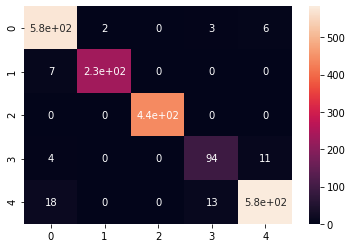

In [53]:
y_pred = grid.predict(X_test)
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True)
plt.show()

In [54]:
data_etc = pd.DataFrame(data={
    'time': times,
    'scores': scores,
    'number_of_features':nf
})

In [55]:
data_etc

,time,scores,number_of_features
0,56.963717,0.912352,2
1,60.446382,0.936149,4
2,61.412790,0.941343,6
3,63.350298,0.937992,8
4,67.631999,0.940339,10
5,68.757726,0.938998,12
6,70.274605,0.938328,14
7,73.961584,0.939166,16
8,74.398745,0.939669,18
9,75.156441,0.939501,20


#SGD

In [56]:
model = SGDClassifier()
hyper_parametrs = {
    'loss':['hinge', 'log', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'], 
}
times = []
scores = []
nf = []
grid = GridSearchCV(estimator=model, param_grid=hyper_parametrs, cv=5, n_jobs=-1)
for f in features_split:
    s = time.time()
    grid.fit(X_train[f], y_train)
    p = time.time() - s
    times.append(p)
    scores.append(grid.best_score_)
    nf.append(len(f))

In [57]:
data_sgd = pd.DataFrame(data={
    'time': times,
    'scores': scores,
    'number_of_features':nf
})

In [58]:
data_sgd

,time,scores,number_of_features
0,2.065404,0.826377,2
1,2.343299,0.844146,4
2,2.565324,0.846658,6
3,2.876440,0.838614,8
4,3.175143,0.865426,10
5,3.460784,0.865594,12
6,3.828526,0.873134,14
7,4.174635,0.868108,16
8,4.435653,0.866766,18
9,5.021394,0.850855,20


In [59]:
grid.best_params_

{'loss': 'modified_huber', 'penalty': 'l1'}

In [60]:
grid.best_score_

0.8954245943323771

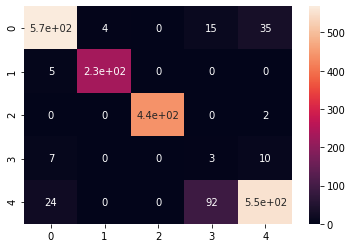

In [61]:
y_pred = grid.predict(X_test)
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True)
plt.show()

# DecisionTreeClassifier

In [62]:
model = DecisionTreeClassifier()
hyper_parametrs = {
    'max_depth':range(2, 50)
}
times = []
scores = []
nf = []
grid = GridSearchCV(estimator=model, param_grid=hyper_parametrs, cv=5, n_jobs=-1)
for f in features_split:
    s = time.time()
    grid.fit(X_train[f], y_train)
    p = time.time() - s
    times.append(p)
    scores.append(grid.best_score_)
    nf.append(len(f))

In [63]:
data_dtc = pd.DataFrame(data={
    'time': times,
    'scores': scores,
    'number_of_features':nf
})

In [64]:
grid.best_params_

{'max_depth': 26}

In [65]:
grid.best_score_

0.9465382233885269

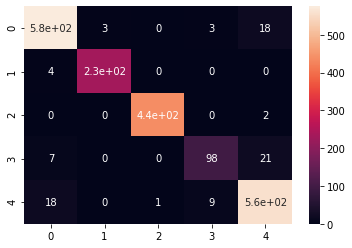

In [66]:
y_pred = grid.predict(X_test)
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True)
plt.show()

# KNN

In [67]:
model = KNeighborsClassifier()
hyper_parametrs = {
    'n_neighbors':range(2, 50),
    'weights':['uniform', 'distance']
}
times = []
scores = []
nf = []
grid = GridSearchCV(estimator=model, param_grid=hyper_parametrs, cv=5, n_jobs=-1)
for f in features_split:
    s = time.time()
    grid.fit(X_train[f], y_train)
    p = time.time() - s
    times.append(p)
    scores.append(grid.best_score_)
    nf.append(len(f))

In [68]:
data_knn = pd.DataFrame(data={
    'time': times,
    'scores': scores,
    'number_of_features':nf
})

In [69]:
data_knn

,time,scores,number_of_features
0,13.818738,0.910676,2
1,14.670166,0.923245,4
2,15.543409,0.934809,6
3,16.449168,0.933469,8
4,17.269814,0.933636,10
5,18.345593,0.934810,12
6,19.266583,0.934140,14
7,21.079801,0.936150,16
8,22.017550,0.935648,18
9,22.947486,0.935647,20


In [70]:
grid.best_params_

{'n_neighbors': 2, 'weights': 'distance'}

In [71]:
grid.best_score_

0.9622924625923694

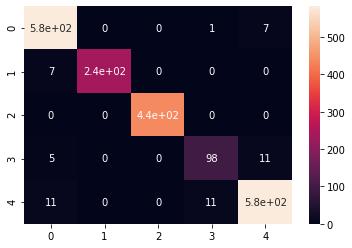

In [72]:
y_pred = grid.predict(X_test)
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True)
plt.show()

# Visual

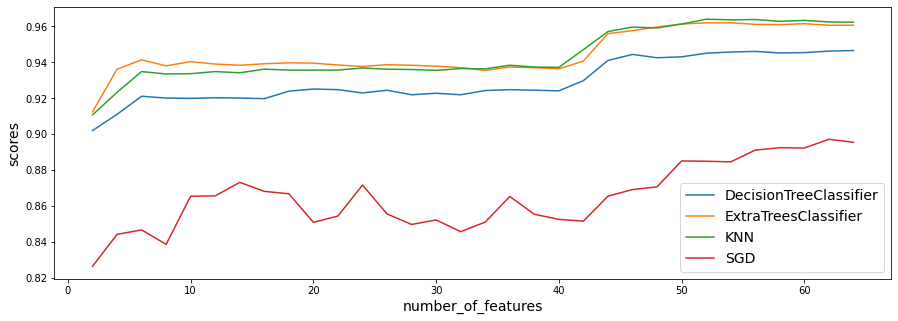

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(data_dtc['number_of_features'], data_dtc['scores'], label='DecisionTreeClassifier')
ax.plot(data_etc['number_of_features'], data_etc['scores'], label='ExtraTreesClassifier')
ax.plot(data_knn['number_of_features'], data_knn['scores'], label='KNN')
ax.plot(data_sgd['number_of_features'], data_sgd['scores'], label='SGD')
ax.legend(fontsize=14)
ax.set_xlabel('number_of_features', fontsize=14)
ax.set_ylabel('scores', fontsize=14)
plt.show()

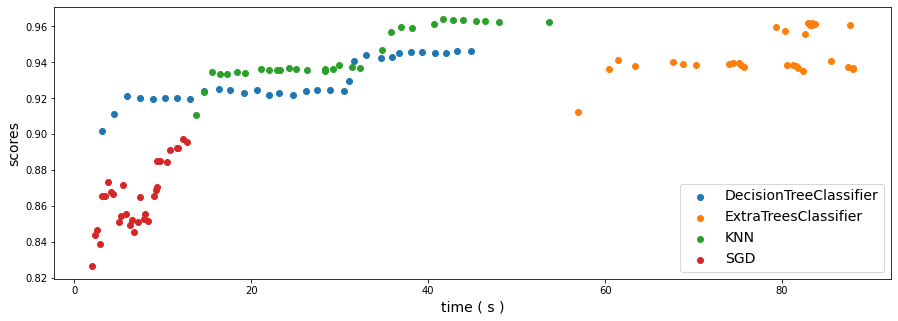

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.scatter(data_dtc['time'], data_dtc['scores'], label='DecisionTreeClassifier')
ax.scatter(data_etc['time'], data_etc['scores'], label='ExtraTreesClassifier')
ax.scatter(data_knn['time'], data_knn['scores'], label='KNN')
ax.scatter(data_sgd['time'], data_sgd['scores'], label='SGD')
ax.legend(fontsize=14)
ax.set_xlabel('time ( s )', fontsize=14)
ax.set_ylabel('scores', fontsize=14)
plt.show()